# Detecting pairwise H-bond between protein and ligand at each milestone

In this note book, we will use the **search_hbonds** function to compute H-bonds between protein-ligand and protein-solvent-ligand. The representaive clusters (with water molecules) generated in **RepreFrame_sparse** will be used to perform the H-bond analysis 

## Load Libraries

In [1]:
import sys
sys.path.append('./modules/')
sys.path.insert(1,'/hdd/si_han/cpptraj_test/pytraj') 

import pytraj as pt
from sklearn.decomposition import PCA
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from interpolateCurve import interpolateCurve
from log_progress import*
from LineBuilder import*

## Load representative clusters frames

In [3]:
reaction_path = '/hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory'
path_id = 0  # specify which path you want to write/load
milestone_path=reaction_path+'/Milestone_%d'%path_id
hbond_path = milestone_path+'/H-bonds_meta'
%cd {hbond_path}

watertop = reaction_path+'/water.prmtop'
repre_cluster = pt.iterload(hbond_path+'/selected_restrt.dcd',watertop)
repre_cluster

/hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory/Milestone_0/H-bonds_meta


pytraj.TrajectoryIterator, 725 frames: 
Size: 1.879911 (GB)
<Topology: 116008 atoms, 35846 residues, 35229 mols, PBC with box type = ortho>
           

## Obtain resname of the ligand
In this example, the ligand is the 620th residue of the system, indexed as 619 in python. We use the following command to extract the resname of the ligand. You can also use VMD to obtain the resname.

In [12]:
ligand_name = [residue.name for residue in repre_cluster.top.residues][619]
ligand_name

'MOL'

## Load milestone index and frame index of representative clusters
You should've all the input files save previously from **Milesoning_Generate** and **RepreFrame_sparse**.

In [4]:
idx2_ = np.load(hbond_path+'/selected_frameidx.npy')
idx_ = np.load(hbond_path+'/selected_midx.npy')

In [5]:
num_milestones = len(list(set(idx_)))

In [6]:
#Using cpptraj to obtain solute-solute, solute-solvent, and solute-solvent-solute H-bons
frameidx = np.array(range(len(repre_cluster)))
for i in log_progress(range(num_milestones)):
    data = pt.search_hbonds(repre_cluster[frameidx[idx_ == i]],
                            distance=3.0, angle=150,
                            solvent_donor=':WAT@O', solvent_acceptor=':WAT',
                           options='avgout UU_%d.dat solvout UV_%d.dat bridgeout bridge_%d.dat'%(i,i,i))

/home/si_han/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/home/si_han/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.


### BASH commands
run the following commands in bash

In [13]:
print("command 1: cd "+hbond_path)
print('command 2: for i in $(ls bridge*); do grep "%s" $i > ${i/_/_%s_}; done'%(ligand_name,ligand_name))

command 1: cd /hdd/si_han/Tools/Milestoning_Distribution/Metadynamics_Trajectory/Milestone_0/H-bonds_meta
command 2: for i in $(ls bridge*); do grep "MOL" $i > ${i/_/_MOL_}; done


## Plot Protein-Ligand Hbonds

In [14]:
Hbond_UU = []
for i in range(num_milestones):
    test = pd.read_csv('UU_%d.dat'%i,sep='\s+|_|@', engine='python',skiprows=1,header=None
                      ,names=['AccepterR','Accepter id','Accepter','DonorR','Donor id','DonorH','DonorR 2',
                            'Donor id 2','Donor','Frames','Frac','AvgDist','AvgAng']
                      )
    
    df1= test[test['AccepterR']=='MOL']
    df2 = test[test['DonorR']=='MOL']
    Hbond_UU.append(pd.concat([df1,df2]))

In [15]:
Hbond_UU_data = []
for k in range(num_milestones):
    if len(Hbond_UU[k]) > 0:
        for i in range(len(Hbond_UU[k])):
            if Hbond_UU[k]['AccepterR'].iloc[i]=='MOL' and Hbond_UU[k]['DonorR'].iloc[i] !='MOL':
                Hbond_UU_data.append([ k, Hbond_UU[k]['DonorR'].iloc[i],Hbond_UU[k]['Donor id'].iloc[i],
                                     Hbond_UU[k]['Accepter'].iloc[i], Hbond_UU[k]['AvgDist'].iloc[i]])
            elif Hbond_UU[k]['DonorR'].iloc[i]=='MOL' and Hbond_UU[k]['AccepterR'].iloc[i]!='MOL':
                Hbond_UU_data.append([ k, Hbond_UU[k]['AccepterR'].iloc[i],Hbond_UU[k]['Accepter id'].iloc[i],
                                     Hbond_UU[k]['DonorH'].iloc[i], Hbond_UU[k]['AvgDist'].iloc[i]])

In [16]:
index=list(range(len(Hbond_UU_data)))
columns=['milestone','residue','residue id','ligand atom','AvgDist']
df_UU = pd.DataFrame(Hbond_UU_data,index=index,columns=columns)
df_UU["residue id"] = pd.to_numeric(df_UU["residue id"])
df_UU.to_csv(hbond_path+'df_UU.csv', sep='\t', index=False)
Rorder = np.sort(np.array(list(set(np.array(df_UU.iloc[:,2])))))

/home/si_han/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


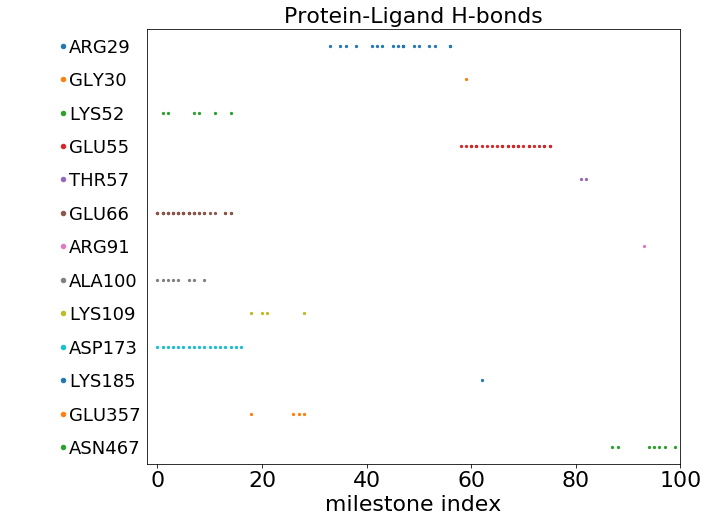

In [17]:
plt.figure(figsize=(12,8))

# subplot 1 for y-ticks and bullet points
fig = plt.subplot2grid((10, 10), (0, 0), rowspan=10)

x = 1.1
for i in range(len(Rorder)):
    y = len(Rorder)-i    
    plt.scatter(x,y,s=20)
    R = df_UU[df_UU.iloc[:,2]==Rorder[i]].iloc[0,1]
    plt.text(x+0.13,y-0.2, "%-3s%-d"%(R,int(Rorder[i])),fontsize=18)

plt.xlim(0,1.2)
plt.ylim(0.5,len(Rorder)+0.5)
plt.yticks(np.arange(1, len(Rorder)+1, 1.0))
plt.yticks([])

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

#########################################################################################################

# subplot 2 for H bonds
fig = plt.subplot2grid((10, 10), (0, 2), colspan=9,rowspan=10)
x = np.array(df_UU.iloc[:,0])
y = np.array(df_UU.iloc[:,2])
for i in range(len(Rorder)):
    index = y == Rorder[i]
    x_ = x[index]
    y_ = [len(Rorder)-i]*len(x_)
    plt.scatter(x_,y_,s=5)

plt.setp(fig.get_yticklabels(),visible=False)
plt.yticks([])
plt.ylim(0.5,len(Rorder)+0.5)
plt.xlim([-2,num_milestones])
plt.xlabel("milestone index",fontsize=22)
plt.title("Protein-Ligand H-bonds",fontsize=22)
plt.tick_params(labelsize=22)
plt.show()

## Plot Protein-Solvent-Ligand Hbonds

In [18]:
import os

Hbond_bridge = []
for i in range(num_milestones):
    file = 'bridge_MOL_%d.dat'%i
    if os.path.exists(file)==False or os.stat(file).st_size == 0:
        Hbond_bridge.append([])
    else:
        tmp = pd.read_csv(file,sep='\s+|:|,',engine='python',header=None, names=list(range(16)))
        tmp = tmp[[2,3,4,5,6,7,8,9,10,11]]
        tmp.columns=['Res 1 id','Res 1','Res 2 id','Res 2','Res 3 id','Res 3','Res 4 id','Res 4','Res 5 id','Res 5']
        Hbond_bridge.append(tmp)

In [19]:
import math

Hbond_bridge_data = []
for k in range(num_milestones):
    if len(Hbond_bridge[k]) > 0:
        for i in range(len(Hbond_bridge[k])):
            for j in range(1,Hbond_bridge[k].shape[1],2):
                r_ = Hbond_bridge[k].iloc[i,j]
                rid_ = Hbond_bridge[k].iloc[i,j-1]
                if r_!='MOL' and math.isnan(rid_)==False and r_!='frames.':
                    Hbond_bridge_data.append([k, r_, rid_] )

In [20]:
df_bridge = pd.DataFrame(Hbond_bridge_data)
Rorder = np.sort(np.array(list(set(np.array(df_bridge.iloc[:,2])))))

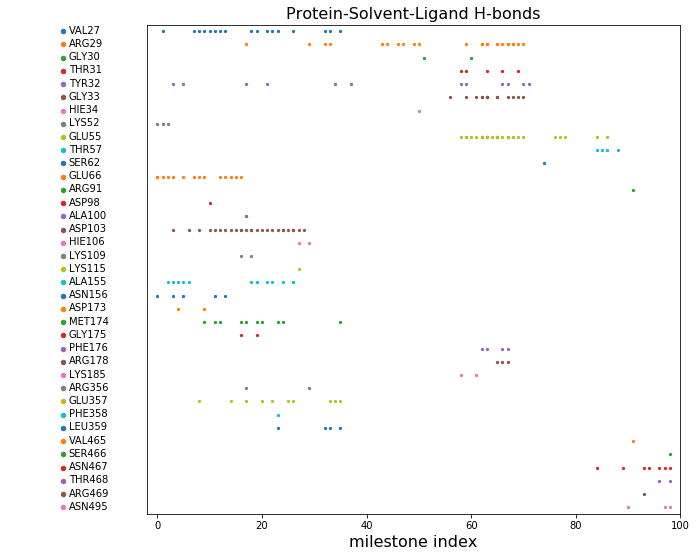

In [21]:
plt.figure(figsize=(12,9))

# subplot 1 for y-ticks and bullet points
fig = plt.subplot2grid((10, 10), (0, 0), rowspan=10)

x = 1.1
for i in range(len(Rorder)):
    y = len(Rorder)-i    
    plt.scatter(x,y,s=20)
    R = df_bridge[df_bridge.iloc[:,2]==Rorder[i]].iloc[0,1]
    plt.text(x+0.13,y-0.15, "%-3s%-d"%(R,int(Rorder[i])))

plt.xlim(0,1.2)
plt.ylim(0.5,len(Rorder)+0.5)
plt.yticks(np.arange(1, len(Rorder)+1, 1.0))
plt.yticks([])

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

#########################################################################################################

# subplot 2 for H bonds
fig = plt.subplot2grid((10, 10), (0, 2), colspan=9,rowspan=10)
x = np.array(df_bridge.iloc[:,0])
y = np.array(df_bridge.iloc[:,2])
for i in range(len(Rorder)):
    index = y == Rorder[i]
    x_ = x[index]
    y_ = [len(Rorder)-i]*len(x_)
    plt.scatter(x_,y_,s=5)

plt.setp(fig.get_yticklabels(),visible=False)
plt.yticks([])
plt.ylim(0.5,len(Rorder)+0.5)
plt.xlim([-2, num_milestones])
plt.xlabel("milestone index",fontsize=16)
plt.title("Protein-Solvent-Ligand H-bonds",fontsize=16)
plt.show()